In [1]:

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time
from astropy.io import fits
import gc
from matplotlib import cm
import pyfftw as fftw
import pyccl
import pandas as pd
import struct
from collections import namedtuple
import sys
import healpy as hp

t0 = time.time()

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 4.32
plt.rcParams['ytick.minor.size'] = 2.46

plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['xtick.minor.width'] = 1.2

plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['ytick.minor.width'] = 1.2

plt.rcParams['figure.facecolor'] = 'w'

In [2]:
from glob import glob
#Directory goes here
lcdir = '/home/users/kokron/scratch/MDPL2-UM/lightcone_s82/'



In [3]:
fnames = glob(lcdir+'*')

a = fits.open(fnames[0])

bigcat = np.array(a[1].data)

start_time = time.time()
#Append slices sequentially to one large array
for i in range(1, len(fnames)):
    b =  fits.open(fnames[i])
#     print(i, fnames[i])
    bigcat = np.append(bigcat, np.array(b[1].data))
print(time.time() - start_time)

425.2372410297394


/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


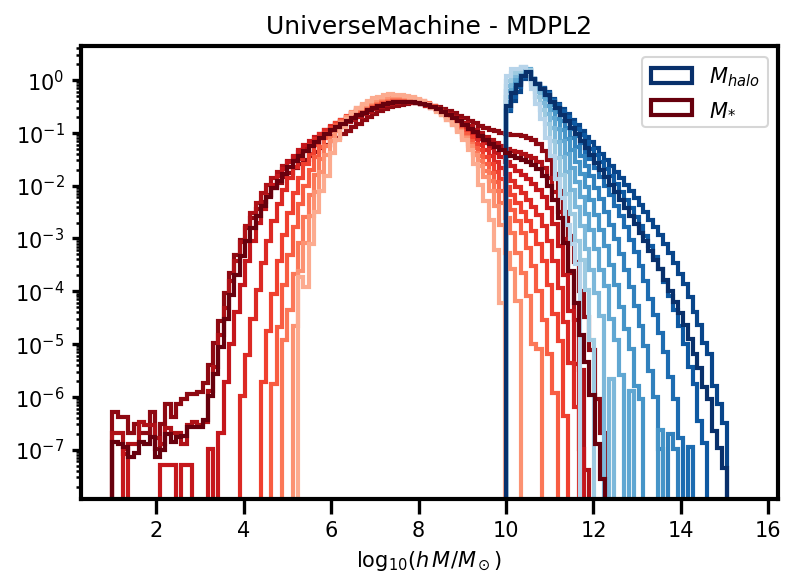

In [4]:
#Look at mass function and stellar mass functions colored by redshift

bins_hm = np.linspace(10, 15.5, 50)
bins_sm = np.linspace(1, 13, 100)

colorh = plt.get_cmap('Blues')(np.linspace(0.999, 0.3, 10))

colorsm = plt.get_cmap('Reds')(np.linspace(0.999, 0.3, 10))


zbins = np.linspace(0, np.max(bigcat['Z']), 10)

for i in range(9):
    
    wheres = (bigcat['Z'] < zbins[i+1])&(bigcat['Z'] > zbins[i])
    
    hmcat = np.log10(bigcat['M_HALO'])[wheres]
    smcat = np.log10(bigcat['SM_HALO'])[wheres]
    
    plt.hist(hmcat, bins=bins_hm, histtype='step', color=colorh[i+1], density=True, lw=2)

    plt.hist(smcat, bins=bins_sm, histtype='step', color=colorsm[i+1], density=True, lw=2)

plt.hist(np.log10(bigcat['M_HALO']), bins=bins_hm, histtype='step', color=colorh[0], density=True, lw=2, label=r'$M_{halo}$')
plt.hist(np.log10(bigcat['SM_HALO']), bins=bins_sm, histtype='step', color=colorsm[0], density=True, lw=2, label=r'$M_{*}$')
      
plt.xlabel(r'$\log_{10} ( h\, M/M_\odot)$ ')
plt.title('UniverseMachine - MDPL2')
plt.legend()
plt.yscale('log')

# Li et al 2015 CO emission model

The Li et al 2015 model has 5 steps, taking you from halos to $L_{CO}$. Using UniverseMachine to go from halo masses to SFR subsumes steps 1 and 2 of his model.

Below we just implement the following steps

## 1. $SFR \to L_{IR}$
Halo-to-halo $L_{IR}$ predictions following
$$SFR = \delta_{MF} \times 10^{-10} L_{IR}$$

## 2. $L_{IR} \to L_{CO}$
from the relation 
$$ \langle \log L_{IR} \rangle = \alpha \langle \log L_{CO}  \rangle + \beta$$

and sampling $\log L_{CO}$ from this relation as a gaussian with scatter $\sigma_{L_{CO}}$


In [5]:
def sfr_to_lir(sfr, deltamf=1):
    '''
    Converts halo star-formation rates to IR luminosity. 
    Input:
    -sfr - star formation rate of the halo in units of Msun/yr
    -deltamf - normalization of the relation which depends on IMF. 
    Output:
    -lir - infrared luminosity for the halo
    '''
    lir = 1e10 * sfr / deltamf
    return lir

def lir_to_loglco(lir, alpha=1.37, beta=-1.74):
    '''
    Mean prediction of CO luminosity from infrared luminosity for each halo.
    Input:
    -lir - IR luminosity of the halo
    -alpha - power law coefficient relating IR and CO luminosities
    -beta - multiplicative normalization for the relation
    Output:
    -loglco - mean log CO luminosity of the halo given IR luminosity
    
    '''
    loglir = np.log10(lir)
    loglco = (loglir - beta)/alpha
    
    return loglco

def sample_lco(sfr, deltamf=1, alpha=1.37, beta=-1.74, sigmalco=0.3):
    '''
    Draw a CO luminosity given halo SFR using the Li+15 parametrization.
    
    Input:
    -sfr - Star formation rate of the halo in units of Msun/yr
    -deltamf - IMF normalization
    -alpha - 
    -beta - 
    -sigmalco - scatter in dex
    
    Output:
    lco
    
    Notes:
    
    arXiv:1503.08833 section 2.2 for math 
    '''
    
    lir = sfr_to_lir(sfr, deltamf)
    loglco = lir_to_loglco(lir, alpha, beta)
    
    loglco_samp = np.random.normal(loglco, sigmalco)
    
    return 10**(loglco_samp)

In [6]:
sfrs = bigcat['SFR_HALO']


st = time.time()


#Sample CO luminosities
lcos = sample_lco(sfrs)

print(time.time() - start_time)

/home/users/kokron/Libraries/miniconda3/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


925.7273044586182


In [7]:
st = time.time()


zbins = np.linspace(1, 3, 21)

mbins = np.linspace(10, 14, 21)

lcobins = np.zeros(shape=(len(zbins)-1, len(mbins)-1))
                   
lcosigma = np.zeros(shape=(len(zbins)-1, len(mbins)-1))

#Sub-splitting catalog into the different z-bins and getting the SFR as a function of mass.
#Might be faster if pre-sorting
for z in range(len(zbins)-1):
    wheres = (bigcat['Z'] < zbins[z+1])&(bigcat['Z'] > zbins[z])

    smallcat = bigcat[wheres]
    smalllcos = lcos[wheres]

#convert from K/km s^-1 pc^-2 to Lsun
    unitfac = 4.9*1e-5
    for i in range(len(mbins)-1):
        hmidx = (smallcat['M_HALO'] > 10**mbins[i])&(smallcat['M_HALO'] < 10**mbins[i+1])

        halos = smallcat[hmidx]
        
        lcos_sub = smalllcos[hmidx]*unitfac

        lcobins[z][i] = np.mean(lcos_sub)

        lcosigma[z][i] = np.std(lcos_sub)
print(time.time() - start_time)

/home/users/kokron/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/users/kokron/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1035.2688539028168


In [8]:
#Load other relations - Gabi made these files

pullen = np.load('Pullen13.npy')
tonyli = np.load('TonyLi.npy')
visballoeb = np.load('VL10.npy')

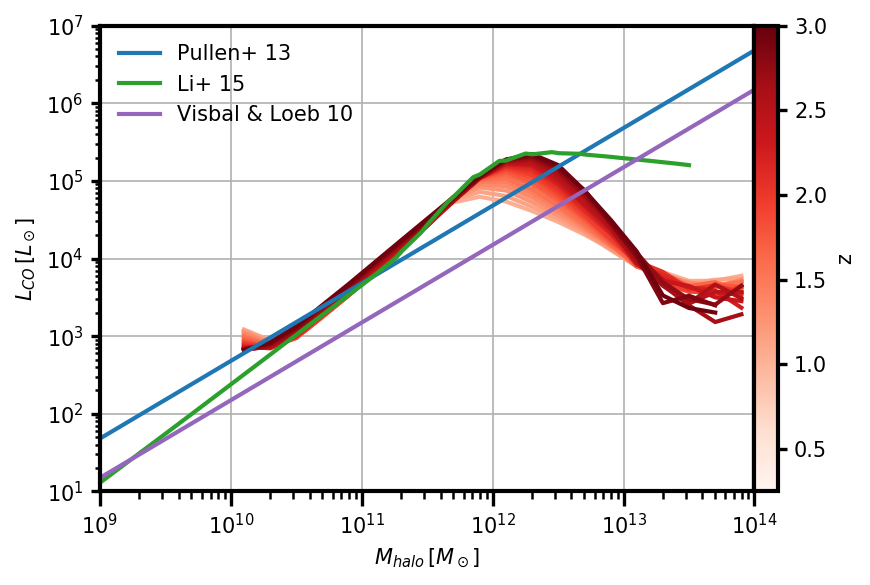

In [9]:
import matplotlib.colors as colors
import matplotlib.cm as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.gridspec as gridspec

mbin_centers = (mbins[:-1] + mbins[1:])*0.5


norm = colors.Normalize(vmin=0.25*zbins[0],vmax=zbins[-1])

s_m = cmap.ScalarMappable(cmap=plt.get_cmap('Reds'), norm=norm)


fig = plt.figure()
gs = gridspec.GridSpec(1,1)

ax = plt.subplot(gs[0,0])

zmids = 0.5*(zbins[:-1] + zbins[1:])

for z in range(len(zbins)-1):
    
    ax.loglog(10**mbin_centers, lcobins[z]*0.677**2, color=s_m.to_rgba(zmids[z]))
#     plt.fill_between(10**mbin_centers * 0.667, lcobins[z] - lcosigma[z], lcobins[z] + lcosigma[z], alpha=0.25)

plt.plot(pullen[0], pullen[1]*0.024, color='C0', label='Pullen+ 13')

plt.plot(tonyli[0][:-1250], tonyli[1][:-1250]*0.677**2, color='C2', label='Li+ 15')

plt.plot(visballoeb[0], visballoeb[1]*0.024, color='C4', label='Visbal & Loeb 10')

# cbaxes = inset_axes(ax, width="25%", height="3%", loc=1)

plt.colorbar(s_m, ax=ax, label='z', pad=0)


ax.set_xlabel(r'$M_{halo} \,[M_\odot]$')
ax.set_ylabel(r'$L_{CO} \, [L_\odot]$')
ax.grid()
ax.set_ylim(1e1, 1e7)
ax.set_xlim(1e9, 1e14)
ax.legend(framealpha=False)
fig.tight_layout()
# fig.savefig('mdpl2UM-columinosity.pdf', format='pdf', dpi=150)

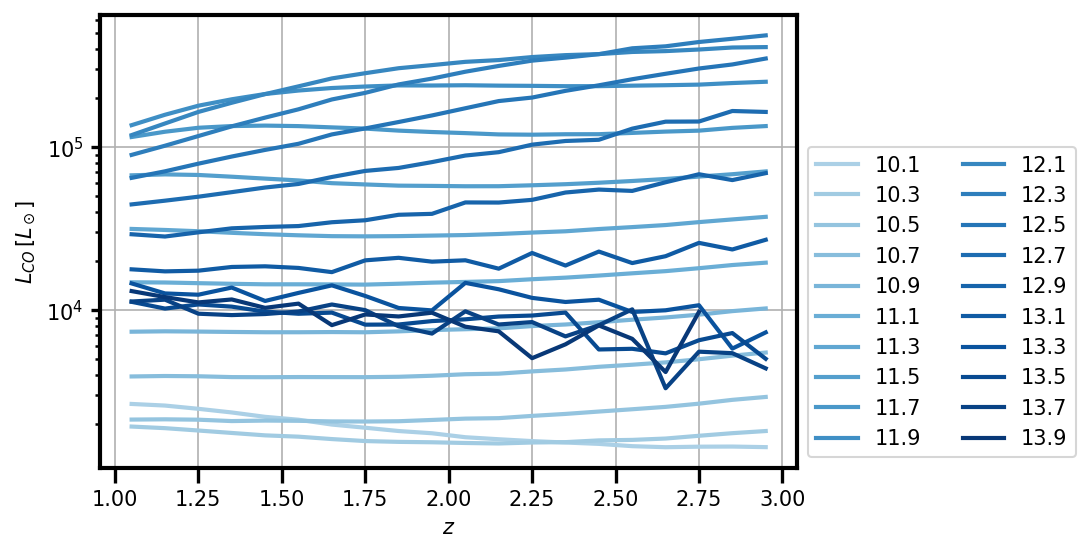

In [10]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)

ax = plt.subplot(gs[0,0])

norm = colors.Normalize(vmin=0.8*mbins[0],vmax=mbins[-1])

s_m = cmap.ScalarMappable(cmap=plt.get_cmap('Blues'), norm=norm)
for i in range(len(mbins)-1):
    ax.semilogy(zmids, lcobins[:,i], color=s_m.to_rgba(mbins[i]), label=mbin_centers[i])
# plt.colorbar(s_m, ax=ax, label=r'$\log_{10} M_{h}/M_\odot$', pad=0)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$L_{CO} \, [L_\odot]$')
ax.legend(ncol=2, loc='lower left', bbox_to_anchor=(1, 0))
ax.grid()

# CO Luminosity functions from UniverseMachine

In [11]:
print(np.min(bigcat['Z']), np.max(bigcat['Z']))

cosmo = pyccl.Cosmology(Omega_c=0.25, Omega_b=0.05,
                            h=0.7, n_s=0.95, sigma8=0.8,
                            transfer_function='bbks')


rmin = pyccl.comoving_radial_distance(cosmo, 1./(np.min(bigcat['Z']) + 1))

rmax = pyccl.comoving_radial_distance(cosmo, 1./(np.max(bigcat['Z']) + 1))

#Volume of lightcone is
#Volume of shell * LC_area / Sphere_Area
lc_volume = 4*np.pi/3 *(rmax**3 - rmin**3) * 312.5/41253


0.0030498833 10.443503


In [12]:
print(lc_volume / (1000)**3)

27.44683625626907


In [13]:
bins = np.linspace(8, 12, 101)
lbincent = 0.5*(bins[1:] + bins[:-1])
luminosityfunc = np.zeros(len(bins)-1)

# lcvol = 


for b in range(len(bins)-1):
    idx = (lcos > 10**bins[b])&(lcos < 10**bins[b+1])
#     sublco = lcos[idx]
    luminosityfunc[b] = np.sum(idx)

# plt.xlim()

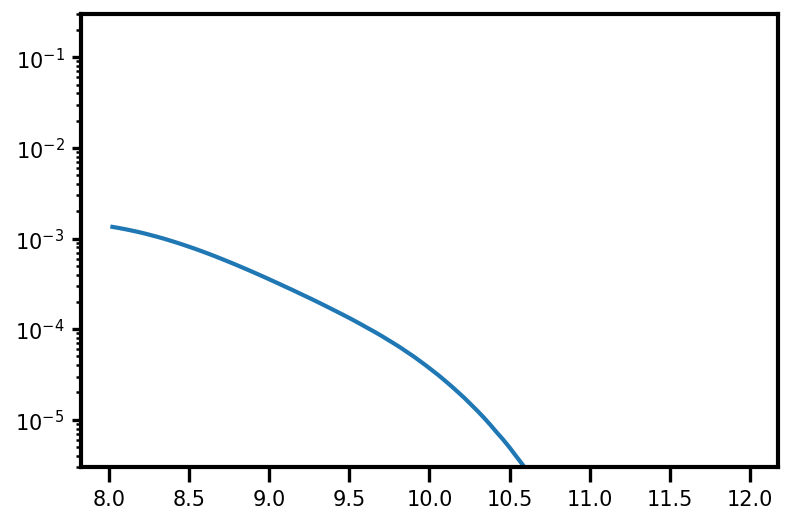

In [14]:
plt.plot(lbincent, luminosityfunc/lc_volume / 0.677**3)
plt.ylim(3e-6, 3e-1)
plt.yscale('log')

# Compare $M_h - SFR$ relations

In [15]:
from scipy.interpolate import interp2d
from scipy.interpolate import CloughTocher2DInterpolator

behroozi_sfr = np.loadtxt('sfr_release.dat')

sfrspline = CloughTocher2DInterpolator(np.array([behroozi_sfr[:,0]-1, behroozi_sfr[:,1]]).T, 10**behroozi_sfr[:,2])

#Pulling from the Moster et al EMERGE catalog at the same redshift - arXiv1705.05373
emerge = np.loadtxt('/home/users/kokron/scratch/EMERGE/galaxies.S24.out')


emerge_hm = emerge[:,0]
emerge_sfr = emerge[:,10]

# sfrspline = interp2d(behroozi_sfr[:,0]-1, behroozi_sfr[:,1], 10**behroozi_sfr[:,2])

In [16]:
#Apologies but this is very disorganized right now

zbins = np.linspace(0, 3, 9)


#planck h
h = 0.677

sfrbins = np.zeros(shape=(len(zbins)-1, len(mbins)-1))
                   
sfrsigma = np.zeros(shape=(len(zbins)-1, len(mbins)-1))

emerge_sfrbin = np.zeros(len(mbins)-1)
emerge_sigma = np.zeros(len(mbins)-1)

behroozi_sfrbin = np.zeros(shape=(len(zbins)-1, len(mbins)-1))

    
for z in range(len(zbins)-1):
    wheres = (bigcat['Z'] < zbins[z+1])&(bigcat['Z'] > zbins[z])

    smallcat = bigcat[wheres]

    #convert from K/km s^-1 pc^-2 to Lsun
    unitfac = 4.9*1e-5
    
    
    behrooziwheres = (behroozi_sfr[:,0]-1 < zbins[z+1])&(behroozi_sfr[:,0]-1 > zbins[z])
    
    smallbehr = behroozi_sfr[behrooziwheres]
    
    for i in range(len(mbins)-1):
        hmidx = (smallcat['M_HALO'] > 10**mbins[i])&(smallcat['M_HALO'] < 10**mbins[i+1])

        
        behrhm = (smallbehr[:,1] > mbins[i])&(smallbehr[:,1] < mbins[i+1])
        
        behroozi_sfrbin[z][i] = np.mean(smallbehr[behrhm,2])
        
        halos = smallcat[hmidx]
        

        halosfr = halos['SFR_HALO']
        sfrbins[z][i] = np.mean(halosfr)

        sfrsigma[z][i] = np.std(halosfr)
        if z == 0:
            emergebin = (emerge_hm > mbins[i])&(emerge_hm < mbins[i+1])
            
            meanemergesfr = np.mean(emerge_sfr[emergebin])
            emerges = np.std(emerge_sfr[emergebin])
            emerge_sfrbin[i] = meanemergesfr
            emerge_sigma[i] = emerges

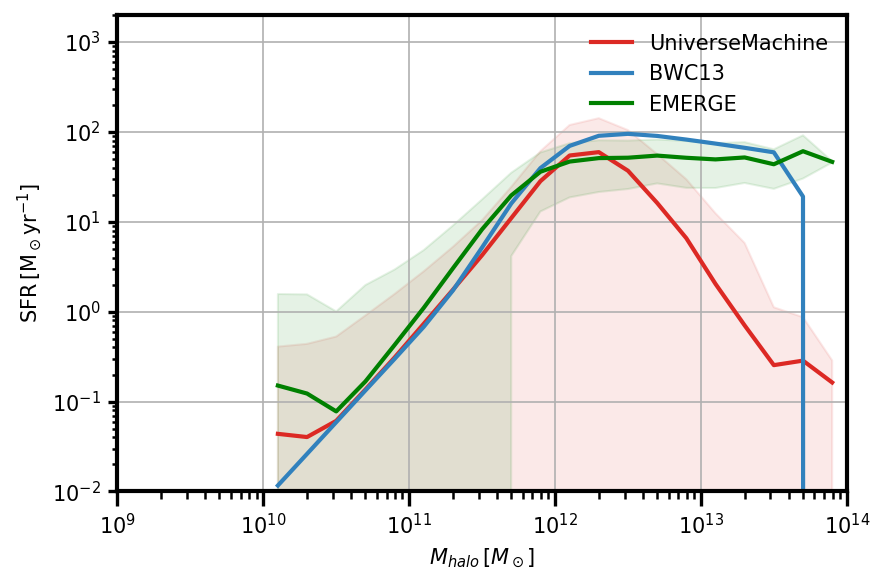

In [17]:
mbin_centers = (mbins[:-1] + mbins[1:])*0.5

# colorsm = plt.get_cmap('Reds')(np.linspace(0.999, 0.3, len(zbins-1)))

norm = colors.Normalize(vmin=0.25*zbins[0],vmax=zbins[-1])

s_m = cmap.ScalarMappable(cmap=plt.get_cmap('Reds'), norm=norm)

s_m2 = cmap.ScalarMappable(cmap=plt.get_cmap('Blues'), norm=norm)

# s_m.set_array([])




fig = plt.figure()
gs = gridspec.GridSpec(1,1)

ax = plt.subplot(gs[0,0])

zmids = 0.5*(zbins[:-1] + zbins[1:])

# for z in range(len(zbins)-1):
    
#     ax.loglog(10**mbin_centers, sfrbins[z], color=s_m.to_rgba(zmids[z]))
#     ax.loglog(10**mbin_centers, sfrspline(zmids[z], mbin_centers), color=s_m2.to_rgba(zmids[z]))
# plt.colorbar(s_m, ax=ax, label='z', pad=0)

ax.loglog(10**mbin_centers, sfrbins[-2], color=s_m.to_rgba(zmids[z-2]), label='UniverseMachine')
ax.fill_between(10**mbin_centers, sfrbins[-2]-sfrsigma[-2], sfrbins[-2]+sfrsigma[-2], alpha=0.1, color=s_m.to_rgba(zmids[z-2]))


ax.loglog(10**mbin_centers, sfrspline(zmids[-2], mbin_centers), color=s_m2.to_rgba(zmids[z-2]), label='BWC13')
ax.loglog(10**mbin_centers, emerge_sfrbin, color='g', label='EMERGE')
ax.fill_between(10**mbin_centers, emerge_sfrbin-emerge_sigma, emerge_sfrbin+emerge_sigma, color='g', alpha=0.1)

ax.set_xlabel(r'$M_{halo} \,[M_\odot]$')
ax.set_ylabel(r'${\rm SFR} \, [{\rm M}_\odot {\rm yr}^{-1}]$')
ax.grid()
ax.set_ylim(1e-2, 2e3)
ax.set_xlim(1e9, 1e14)

ax.legend(framealpha=False)
fig.tight_layout()

In [33]:
# np.save('sfr_UM.npy', np.array([10**mbin_centers, sfrbins[-2]]))

# Looks weird -- compare to the full snapshot

This snippet just compares to loading in a full snapshot instead of only our light cone slice. The statistics are very comparable to each other. 

In [ ]:
import gc
dtype = np.dtype(dtype=[('id', 'i8'),('descid','i8'),('upid','i8'),
                        ('flags', 'i4'), ('uparent_dist', 'f4'),
                        ('pos', 'f4', (6)), ('vmp', 'f4'), ('lvmp', 'f4'),
                        ('mp', 'f4'), ('m', 'f4'), ('v', 'f4'), ('r', 'f4'),
                        ('rank1', 'f4'), ('rank2', 'f4'), ('ra', 'f4'),
                        ('rarank', 'f4'), ('A_UV', 'f4'), ('sm', 'f4'),
                        ('icl', 'f4'), ('sfr', 'f4'), ('obs_sm', 'f4'),
                        ('obs_sfr', 'f4'), ('obs_uv', 'f4'), ('empty', 'f4')],
                 align=True)

fullcat = np.fromfile('/home/users/kokron/scratch/MDPL2-UM/sfr_catalog_0.295700.bin', dtype=dtype)


sublabels = ['m', 'sfr', 'mp']
subcat = fullcat[sublabels]
del fullcat
gc.collect()

In [ ]:
mbins = np.linspace(10, 14, 51)

sfr_snap = subcat['sfr']

sfr_snapbins = np.zeros(len(mbins)-1)


sfr_mpbins = np.zeros(len(mbins)-1)

sfr_std = np.zeros(len(mbins)-1)
lcoscat_snap = np.zeros(shape=(len(mbins)-1, 2))


for i in range(len(mbins)-1):
    hmidx = (subcat['m'] > 10**mbins[i])&(subcat['m'] < 10**mbins[i+1])
    
    
#     mpidx = (subcat['mp'] > 10**mbins[i])&(subcat['mp'] < 10**mbins[i+1])
    
#     halos = subcat[hmidx]
    sfr_sub = sfr_snap[hmidx]
    
#     sfr_mpbins[i] = np.mean(sfr_snap[mpidx])
    
    
    sfr_snapbins[i] = np.mean(sfr_sub)
    
    sfr_std[i] = np.std(sfr_sub)
    lcoscat_snap[i][0] = np.quantile(sfr_sub, 0.84)
    lcoscat_snap[i][1] = np.quantile(sfr_sub, 0.16)

In [ ]:
mbin_centers = (mbins[:-1] + mbins[1:])*0.5


plt.loglog(10**mbin_centers, sfr_snapbins, color='b', label='Snapshot UM')

# plt.loglog(10**mbin_centers, sfr_mpbins, color='g', label='Mpeak UM')

plt.loglog(10**np.linspace(10, 15, 21),  np.abs(sfrspline(1./0.295700 - 1, np.linspace(10, 15, 21))), color='r', label='Behroozi et al 2013')
plt.fill_between(10**mbin_centers, sfr_snapbins-sfr_std, sfr_std+sfr_snapbins, alpha=0.25, color='b')


# plt.loglog(10**mbin_centers* 0.667, lcobins_snap, color='r', label='Snapshot')
# plt.fill_between(10**mbin_centers * 0.667, lcoscat_snap[:,1], lcoscat_snap[:,0], alpha=0.25, color='r')

plt.legend()

plt.xlabel(r'$M_{halo} \,[M_\odot]$')
plt.ylabel(r'${\rm SFR} \, [{\rm M}_\odot {\rm yr}^{-1}]$')
plt.ylim(1e-1, 1e3)
plt.xlim(1e10, 1e14)

In [ ]:
mbin_centers

In [ ]:
sfrspline

In [ ]:
plt.scatter(behroozi_sfr[:,0]-1, behroozi_sfr[:,1], c=behroozi_sfr[:,2], vmin=0, vmax=2)
plt.colorbar()

In [ ]:
plt.scatter()